In [2]:
import pandas as pd
import numpy as np
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm import cross_validation
from lightfm.evaluation import auc_score, precision_at_k
import itertools

/Users/pintu/Documents/skilvul/venv/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Exploratory Data Analysis

In [3]:
df_interactions = pd.read_csv('../dataset/new/customer_interactions.csv')
display(df_interactions.head())
print(df_interactions.shape)

,customer_id,page_views,time_spent
0,1,25,120
1,2,20,90
2,3,30,150
3,4,15,80
4,5,22,110


(20, 3)


In [4]:
df_purchases = pd.read_csv('../dataset/new/purchase_history.csv')
display(df_purchases.head())
print(df_purchases.shape)

,customer_id,product_id,purchase_date
0,1,101,2023-01-01
1,1,105,2023-01-05
2,2,102,2023-01-02
3,3,103,2023-01-03
4,4,104,2023-01-04


(100, 3)


In [5]:
df_products = pd.read_csv('../dataset/new/product_details.csv')
display(df_products.head())
print(df_products.shape)

,product_id,category,price,ratings
0,101,Electronics,500,4.5
1,102,Clothing,50,3.8
2,103,Home & Kitchen,200,4.2
3,104,Beauty,30,4.0
4,105,Electronics,800,4.8


(500, 4)


In [6]:
# analyzing interactions
df_interactions.describe()

,customer_id,page_views,time_spent
count,20.00000,20.000000,20.000000
mean,10.50000,30.350000,250.250000
std,5.91608,10.312358,115.514353
min,1.00000,11.000000,80.000000
25%,5.75000,24.250000,117.500000
50%,10.50000,32.000000,288.000000
75%,15.25000,36.000000,324.000000
max,20.00000,49.000000,441.000000


<Axes: >

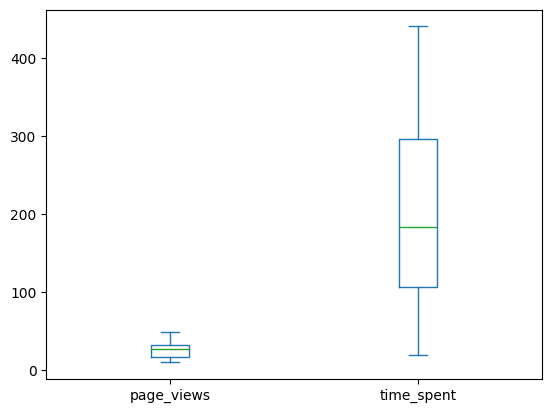

In [7]:
df_interactions.describe()[['page_views', 'time_spent']].plot(kind='box')

<Axes: ylabel='Frequency'>

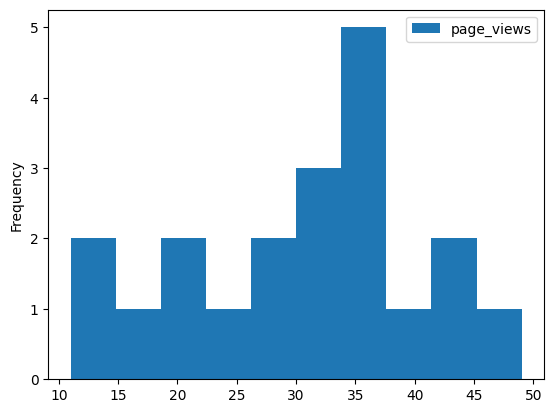

In [8]:
display(df_interactions[['page_views']].plot.hist())

<Axes: ylabel='Frequency'>

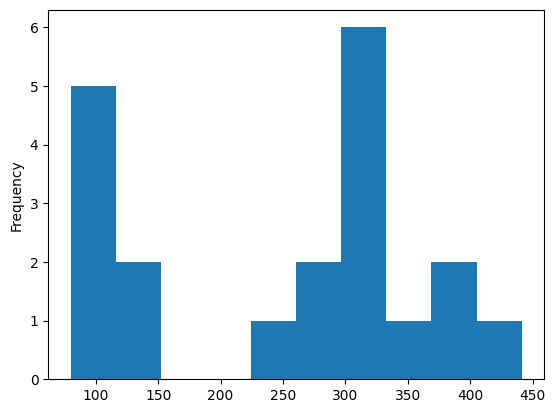

In [9]:
display(df_interactions['time_spent'].plot(kind='hist'))

In [10]:
display(df_interactions[['page_views', 'time_spent']].corr())

,page_views,time_spent
page_views,1.000000,0.941059
time_spent,0.941059,1.000000


In [11]:
df_products.describe()

,product_id,price,ratings
count,500.000000,500.000000,500.000000
mean,350.500000,733.700000,3.564600
std,144.481833,431.905539,0.856829
min,101.000000,20.000000,2.000000
25%,225.750000,347.500000,2.800000
50%,350.500000,725.000000,3.600000
75%,475.250000,1102.500000,4.300000
max,600.000000,1490.000000,5.000000


In [12]:
df_products.category.value_counts()

category
Beauty            137
Home & Kitchen    125
Clothing          121
Electronics       117
Name: count, dtype: int64

In [13]:
df_products[['price', 'ratings']].corr()

,price,ratings
price,1.000000,-0.001958
ratings,-0.001958,1.000000


In [14]:
df_products[['category', 'ratings', 'price']].groupby('category').describe()

ratings                                               price  \
                 count      mean       std  min  25%  50%  75%  max  count   
category                                                                     
Beauty           137.0  3.528467  0.861168  2.0  2.8  3.5  4.3  5.0  137.0   
Clothing         121.0  3.675207  0.904644  2.0  2.9  3.8  4.4  5.0  121.0   
Electronics      117.0  3.515385  0.882943  2.0  2.8  3.5  4.3  5.0  117.0   
Home & Kitchen   125.0  3.543200  0.776919  2.0  2.9  3.5  4.1  5.0  125.0   

                                                                            
                      mean         std   min    25%    50%     75%     max  
category                                                                    
Beauty          707.007299  428.192791  30.0  340.0  690.0  1050.0  1460.0  
Clothing        732.314050  443.179347  20.0  340.0  730.0  1090.0  1490.0  
Electronics     777.350427  421.101579  20.0  490.0  800.0  1150.0  1490.0  
Home & Kitchen  723.440000  436.965533  20.0  340.0  680.0  1140.0  1490.0

<Axes: xlabel='category'>

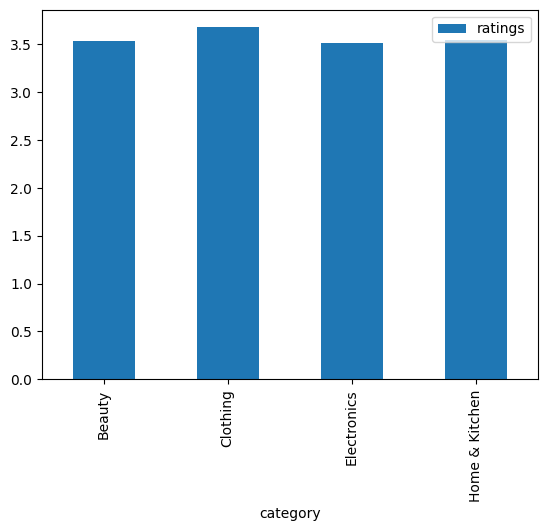

In [15]:
df_products.groupby('category')[['ratings']].mean().plot(kind='bar')

In [16]:
display(df_purchases.describe())
display(df_purchases.describe(include=['O']))

,customer_id,product_id
count,100.000000,100.000000
mean,9.790000,331.870000
std,5.815853,159.881879
min,1.000000,101.000000
25%,5.000000,181.750000
50%,9.000000,328.500000
75%,15.000000,475.500000
max,20.000000,591.000000


,purchase_date
count,100
unique,67
top,2023-01-18 00:00:00
freq,5


In [17]:
df_purchases.groupby('customer_id').count().sort_values('purchase_date', ascending=False)

,product_id,purchase_date
customer_id,,
9,8,8
2,8,8
3,7,7
5,7,7
18,7,7
10,7,7
12,6,6
1,5,5
15,5,5


<Axes: xlabel='purchase_date'>

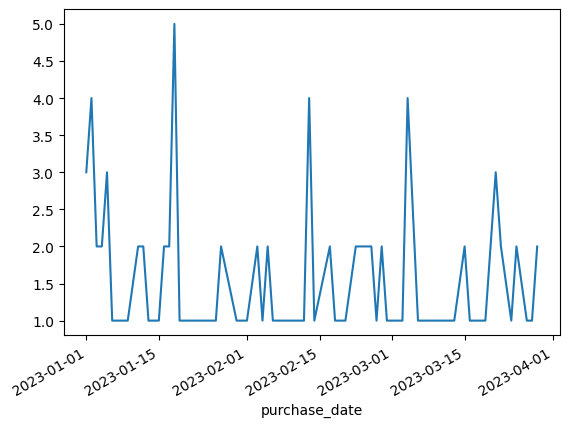

In [18]:
df_purchases['purchase_date'] = pd.to_datetime(df_purchases['purchase_date'].str.replace(' 00:00:00', ''))
df_purchases.groupby('purchase_date')['product_id'].count().plot(kind='line')

14.325


<Axes: ylabel='Frequency'>

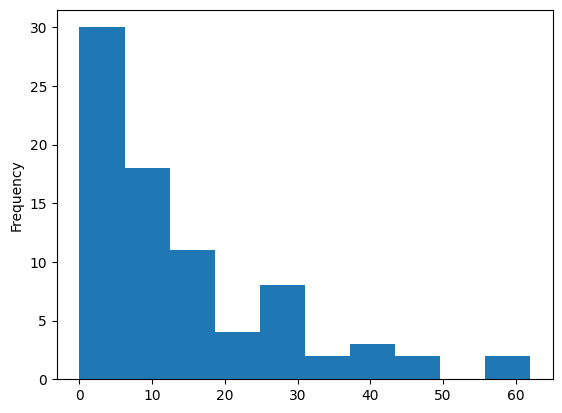

In [19]:
df_eda_recency = df_purchases.sort_values(['customer_id', 'purchase_date']).groupby('customer_id')
time_since_last_purchase = df_eda_recency['purchase_date'].diff().dt.days
print(np.mean(time_since_last_purchase))
time_since_last_purchase.plot(kind='hist')

**Conclusion**

- time_spent and page_views are highly correlated
- purchase_date doesn't have any trend
- there is no correlation between price and ratings
- most cheapest items is beauty category
- electroinic has highest starting price

**Action Items**
- change purchase_date into boolean (buy/no)
- preprocess users and items feature

In [20]:
map_user_id = {}
map_product_id = {}
for ix, user in enumerate(df_interactions.customer_id.unique()):
    map_user_id[user] = ix

for ix, user in enumerate(df_products.product_id.unique()):
    map_product_id[user] = ix

df_products['product_id_int'] = df_products['product_id'].map(map_product_id)
df_interactions['customer_id_int'] = df_interactions['customer_id'].map(map_user_id)
df_purchases['customer_id_int'] = df_purchases['customer_id'].map(map_user_id)
df_purchases['product_id_int'] = df_purchases['product_id'].map(map_product_id)

In [21]:
users = df_interactions.copy()
user_ids = set(users['customer_id_int'].tolist())

# users['time_spent'] = np.digitize(users['time_spent'], np.percentile(users['time_spent'],[25,50,75]))
# users['page_views'] = np.digitize(users['page_views'], np.percentile(users['page_views'],[25,50,75]))

user_features = users[['time_spent', 'page_views']].apply(
            lambda x: ','.join(x.map(str)), axis=1)
user_features = user_features.str.split(',')
user_features = user_features.apply(pd.Series).stack().reset_index(drop=True)

id_user_features = users[['customer_id_int', 'page_views', 'time_spent']].apply(
    lambda row: (row['customer_id_int'], [str(row['page_views']), str(row['time_spent'])]), axis=1
)
print(len(user_ids))
user_features

20


0     120
1      25
2      90
3      20
4     150
5      30
6      80
7      15
8     110
9      22
10    378
11     42
12    441
13     49
14    324
15     36
16    324
17     36
18    297
19     33
20    378
21     42
22    108
23     12
24    360
25     40
26    279
27     31
28    324
29     36
30    252
31     28
32    306
33     34
34    261
35     29
36    324
37     36
38     99
39     11
dtype: object

In [22]:
items = df_products.copy()
items['price'] = items['price'].apply(lambda x: int(x))
items['ratings'] = items['ratings'].apply(lambda x: round(x,1))

item_ids = set(items.product_id_int.tolist())

item_features = items[['category', 'price', 'ratings']].apply(
            lambda x: ','.join(x.map(str)), axis=1)
item_features = item_features.str.split(',')
item_features = item_features.apply(pd.Series).stack().reset_index(drop=True)

id_item_features = items[['product_id_int', 'category', 'price', 'ratings']].apply(
    lambda row: (row['product_id_int'], [str(row['category']), str(row['ratings'])]), axis=1
)
print(len(item_ids))
item_features

500


0       Electronics
1               500
2               4.5
3          Clothing
4                50
           ...     
1495           1090
1496            2.0
1497    Electronics
1498            720
1499            3.4
Length: 1500, dtype: object

In [23]:
interactions = df_purchases.copy()
interactions['is_purchased'] = interactions['purchase_date'].apply(lambda x : 1 if x is not None else None)
interactions = interactions[['customer_id_int', 'product_id_int', 'is_purchased']].groupby(['customer_id_int', 'product_id_int']).sum().reset_index()
interactions = pd.merge(interactions, df_products, on=['product_id_int'], how='left')
interactions['weight'] = interactions['is_purchased']

interactions = interactions[['customer_id_int', 'product_id_int', 'weight']]
interactions = list(zip(interactions.customer_id_int, interactions.product_id_int, interactions.weight))
interactions

[(0, 0, 1),
 (0, 4, 1),
 (0, 120, 1),
 (0, 184, 1),
 (0, 340, 1),
 (1, 1, 1),
 (1, 64, 1),
 (1, 206, 1),
 (1, 248, 1),
 (1, 315, 1),
 (1, 344, 1),
 (1, 373, 1),
 (1, 472, 1),
 (2, 2, 1),
 (2, 26, 1),
 (2, 259, 1),
 (2, 261, 1),
 (2, 304, 1),
 (2, 402, 1),
 (2, 463, 1),
 (3, 3, 1),
 (3, 232, 1),
 (3, 477, 1),
 (4, 0, 1),
 (4, 74, 1),
 (4, 131, 1),
 (4, 138, 1),
 (4, 397, 1),
 (4, 416, 1),
 (4, 450, 1),
 (5, 17, 1),
 (5, 24, 1),
 (5, 61, 1),
 (5, 253, 1),
 (6, 3, 1),
 (6, 34, 1),
 (6, 361, 1),
 (6, 364, 1),
 (6, 431, 1),
 (7, 131, 1),
 (7, 166, 1),
 (7, 343, 1),
 (7, 444, 1),
 (8, 18, 1),
 (8, 40, 1),
 (8, 51, 1),
 (8, 147, 1),
 (8, 256, 1),
 (8, 311, 1),
 (8, 463, 1),
 (8, 483, 1),
 (9, 37, 1),
 (9, 125, 1),
 (9, 196, 1),
 (9, 263, 1),
 (9, 382, 1),
 (9, 430, 1),
 (9, 458, 1),
 (10, 161, 1),
 (10, 193, 1),
 (10, 296, 1),
 (11, 67, 1),
 (11, 243, 1),
 (11, 333, 1),
 (11, 425, 1),
 (11, 453, 1),
 (11, 459, 1),
 (12, 41, 1),
 (12, 130, 1),
 (12, 484, 1),
 (13, 54, 1),
 (13, 88, 1),
 (13, 4

In [24]:
dataset = Dataset()
dataset.fit(
            user_ids, 
            item_ids,
            item_features=item_features, 
            user_features=user_features)
dataset

In [25]:
interactions, weight = dataset.build_interactions(interactions)

In [26]:
item_features = dataset.build_item_features(
    id_item_features)

user_features = dataset.build_user_features(
    id_user_features)

In [27]:
train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=24)
train

<20x500 sparse matrix of type '<class 'numpy.int32'>'
	with 80 stored elements in COOrdinate format>

In [28]:
model = LightFM(
    no_components=100,
    learning_rate=0.05,
    loss='warp-kos',
    random_state=24
)

model.fit(
    train,
    item_features=item_features,
    user_features=user_features,
    epochs=10, num_threads=4, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [29]:
def calculate_score(lightfm_model, interactions_matrix,
                        item_features, user_features): 
    score = auc_score( 
        lightfm_model, interactions_matrix,
        item_features=item_features, 
        user_features=user_features, 
        num_threads=4).mean()
    print("Mean AUC Score :", score)
    score_k = precision_at_k( 
        lightfm_model, interactions_matrix,
        item_features=item_features, 
        user_features=user_features, 
        num_threads=4).mean()
    print("Precision at K Score:", score_k)
    return score, score_k

In [30]:
calculate_score(model, train, item_features, user_features)
calculate_score(model, test, item_features, user_features)

Mean AUC Score : 0.9178958
Precision at K Score: 0.1
Mean AUC Score : 0.52082294
Precision at K Score: 0.0


(0.52082294, 0.0)

In [31]:
model.predict([1], [101], item_features, user_features)

array([-0.7783641], dtype=float32)

### Hyperparameter tuning

In [32]:
def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }

In [33]:
def random_search(train, test, num_samples=10, num_threads=4, item_features=None, user_features=None):
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads, item_features=item_features, user_features=user_features)

        score = auc_score(model, test, train_interactions=train, num_threads=num_threads, item_features=item_features, user_features=user_features).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)


(score, hyperparams, model) = max(random_search(train, test, num_threads=2, item_features=item_features, user_features=user_features), key=lambda x: x[0])

print("Best score {} at {}".format(score, hyperparams))

Best score 0.5373913645744324 at {'no_components': 57, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.03199534267277087, 'item_alpha': 1.5471772734012532e-08, 'user_alpha': 7.168567987576306e-10, 'max_sampled': 13, 'num_epochs': 13}


In [34]:
model.predict([1], [101], item_features, user_features)

array([-0.5771019], dtype=float32)

### Save best model

In [35]:
import pickle
with open('lightfm.pickle', 'wb') as f:
    pickle.dump(model, f)

### Create simple prediction

In [36]:
def make_predictions_rank(user_id):
    purchased_ids = set(df_purchases.loc[df_purchases.customer_id == user_id].product_id_int.tolist())
    item_ids = list(set(df_products.loc[~df_products.product_id_int.isin(purchased_ids)].product_id_int.tolist()))
    df_last_buy = df_products.loc[df_products.product_id_int.isin(purchased_ids)]
    scores = model.predict(user_id, item_ids, item_features, user_features)
    df_recommend = df_products.loc[df_products.product_id_int.isin(item_ids)]
    df_recommend['score'] = scores
    df_recommend = df_recommend.sort_values('score', ascending=False).iloc[:10]
    return df_last_buy, df_recommend

last_buy, recommend = make_predictions_rank(1)
display(last_buy)
display(recommend)

/var/folders/n4/4m0c1r8d1jldkcvf4xtdbvqc0000gn/T/ipykernel_1031/1120856682.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recommend['score'] = scores


,product_id,category,price,ratings,product_id_int
0,101,Electronics,500,4.5,0
4,105,Electronics,800,4.8,4
120,221,Home & Kitchen,500,3.3,120
184,285,Beauty,1110,2.3,184
340,441,Home & Kitchen,900,2.8,340


,product_id,category,price,ratings,product_id_int,score
193,294,Electronics,260,4.2,193,-0.254274
131,232,Electronics,1160,4.2,131,-0.258533
483,584,Electronics,610,2.0,483,-0.261715
477,578,Electronics,280,3.8,477,-0.272206
83,184,Electronics,190,3.1,83,-0.281206
379,480,Electronics,1010,3.1,379,-0.288330
125,226,Electronics,1220,2.8,125,-0.333105
248,349,Electronics,440,2.5,248,-0.340216
1,102,Clothing,50,3.8,1,-0.342420
40,141,Electronics,1250,4.7,40,-0.342539
